# Heart Disease Prediction Using Logistic Regression

##  Project Overview

This notebook demonstrates a complete machine learning pipeline for **heart disease prediction** using the famous Cleveland Heart Disease dataset from the UCI Machine Learning Repository. The dataset contains patient characteristics from the Cleveland Clinic Foundation, where researchers recorded various medical indicators to classify the presence of heart disease.

### Objectives
- Build a logistic regression model to predict heart disease presence
- Explore and analyze patient characteristics
- Evaluate model performance using multiple metrics
- Interpret coefficients for clinical insights

###  Dataset Information
The dataset includes patient information such as:
- **Demographics**: Age, sex
- **Clinical measurements**: Blood pressure, cholesterol, heart rate
- **Diagnostic tests**: ECG results, exercise-induced symptoms
- **Target variable**: Heart disease presence (0 = absent, 1 = present)

## Required Libraries


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [36]:
# Load in the heart disease dataset
heart = pd.read_csv(r"C:\Users\Pranav\Downloads\heart_disease.csv")

# Dataset Exploration

## Dataset Features

In [37]:
# Columns in the dataset
heart.columns

Index(['Unnamed: 0', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'present'],
      dtype='object')

## Target Variable Analysis

The **`present`** column represents our binary outcome of interest:
- **`0`**: Absence of heart disease  
- **`1`**: Presence of heart disease

## Dataset Overview


In [38]:
heart.head

<bound method NDFrame.head of      Unnamed: 0  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  \
0             1   63    1   1       145   233    1        2      150      0   
1             2   67    1   4       160   286    0        2      108      1   
2             3   67    1   4       120   229    0        2      129      1   
3             4   37    1   3       130   250    0        0      187      0   
4             5   41    0   2       130   204    0        2      172      0   
..          ...  ...  ...  ..       ...   ...  ...      ...      ...    ...   
298         299   45    1   1       110   264    0        0      132      0   
299         300   68    1   4       144   193    1        0      141      0   
300         301   57    1   4       130   131    0        0      115      1   
301         302   57    0   2       130   236    0        2      174      0   
302         303   38    1   3       138   175    0        0      173      0   

     oldpeak  slope  

## Heart Disease Distribution

In [39]:

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


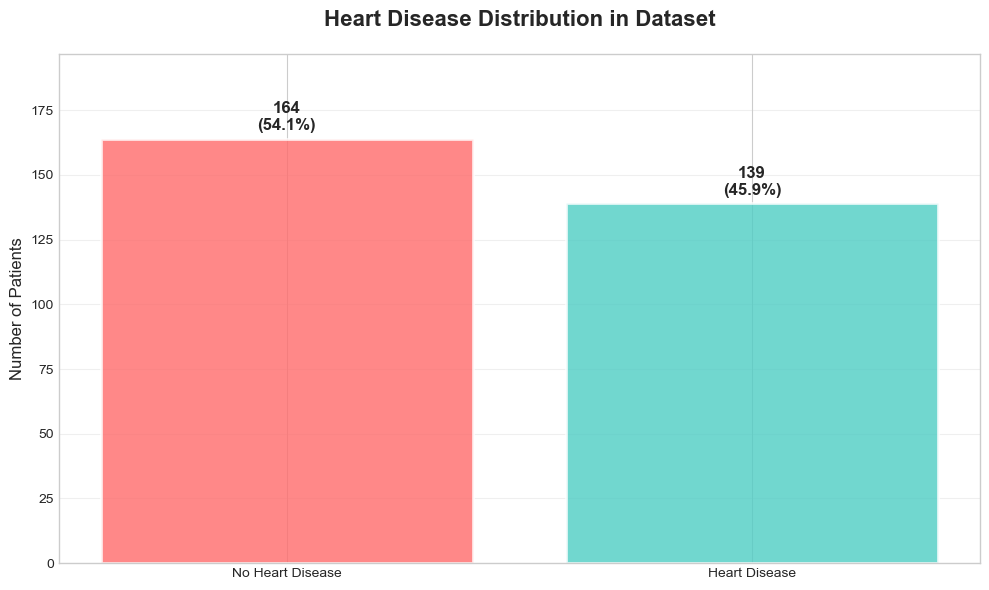

In [40]:
# Create enhanced histogram
fig, ax = plt.subplots(figsize=(10, 6))

counts = heart['present'].value_counts().sort_index()
colors = ['#FF6B6B', '#4ECDC4']

bars = ax.bar(['No Heart Disease', 'Heart Disease'], counts.values, 
              color=colors, alpha=0.8, edgecolor='white', linewidth=2)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, counts.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{count}\n({count/len(heart)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_title('Heart Disease Distribution in Dataset', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Number of Patients', fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(counts.values) * 1.2)

plt.tight_layout()
plt.show()

##  Key Finding

The dataset shows an **almost equal distribution** between patients with and without heart disease (160 vs 137), which is excellent for building a balanced classification model. This eliminates concerns about class imbalance that often plague medical datasets.

In [41]:
print(heart.dtypes)

# Check for non-numeric values in each column
for col in ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
           "thalach", "exang", "oldpeak", "slope", "ca", "thal"]:
    print(f"\n{col}:")
    print(f"  Data type: {heart[col].dtype}")
    print(f"  Unique values: {heart[col].nunique()}")
    if heart[col].dtype == 'object':
        print(f"  Sample values: {heart[col].head().tolist()}")

Unnamed: 0      int64
age             int64
sex             int64
cp              int64
trestbps        int64
chol            int64
fbs             int64
restecg         int64
thalach         int64
exang           int64
oldpeak       float64
slope           int64
ca             object
thal           object
present         int64
dtype: object

age:
  Data type: int64
  Unique values: 41

sex:
  Data type: int64
  Unique values: 2

cp:
  Data type: int64
  Unique values: 4

trestbps:
  Data type: int64
  Unique values: 50

chol:
  Data type: int64
  Unique values: 152

fbs:
  Data type: int64
  Unique values: 2

restecg:
  Data type: int64
  Unique values: 3

thalach:
  Data type: int64
  Unique values: 91

exang:
  Data type: int64
  Unique values: 2

oldpeak:
  Data type: float64
  Unique values: 40

slope:
  Data type: int64
  Unique values: 3

ca:
  Data type: object
  Unique values: 5
  Sample values: ['0.0', '3.0', '2.0', '0.0', '0.0']

thal:
  Data type: object
  Unique values: 4


In [42]:
numeric_columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                  "thalach", "exang", "oldpeak", "slope", "ca", "thal"]

for col in numeric_columns:
    heart[col] = pd.to_numeric(heart[col], errors='coerce')

# Check for NaN values that resulted from conversion
print("NaN counts after conversion:")
print(heart[numeric_columns].isnull().sum())

NaN counts after conversion:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64


In [43]:
heart_clean = heart.dropna()

# Option B: Fill NaN values with median/mode
heart_filled = heart.copy()
for col in numeric_columns:
    if heart_filled[col].isnull().sum() > 0:
        heart_filled[col] = heart_filled[col].fillna(heart_filled[col].median())

In [44]:
result = heart_clean.groupby("present").agg({
    "age": "mean",
    "sex": "mean", 
    "cp": "mean",
    "trestbps": "mean",
    "chol": "mean",
    "fbs": "mean",
    "restecg": "mean",
    "thalach": "mean",
    "exang": "mean",
    "oldpeak": "mean",
    "slope": "mean",
    "ca": "mean",
    "thal": "mean"
})

print(result)

               age       sex        cp    trestbps        chol       fbs  \
present                                                                    
0        52.643750  0.556250  2.793750  129.175000  243.493750  0.143750   
1        56.759124  0.817518  3.583942  134.635036  251.854015  0.145985   

          restecg     thalach     exang   oldpeak     slope        ca  \
present                                                                 
0        0.843750  158.581250  0.143750  0.598750  1.412500  0.275000   
1        1.175182  139.109489  0.540146  1.589051  1.824818  1.145985   

             thal  
present            
0        3.787500  
1        5.832117  


## Feature Selection Strategy

### Selected Features for Model:

1. **`age`** - Patient age (established cardiovascular risk factor)
2. **`thalach`** - Maximum heart rate achieved during stress test  
3. **`restecg`** - Resting electrocardiographic results
4. **`ca`** - Number of major vessels colored by fluoroscopy (0-3)

These features demonstrate noticeable differences between heart disease positive and negative cases, making them strong candidates for our predictive model.

## 📊 Train-Test Split Strategy

We'll implement a **70-30 split** approach for robust model evaluation:
- **70%** for training the model 
- **30%** for testing and final evaluation

This split provides sufficient training data while maintaining a substantial test set for unbiased performance assessment.


In [45]:

heart_clean = heart.dropna()
X = heart_clean[["age", "thalach", "restecg", "ca"]]
y = heart_clean["present"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

## Split Validation
# Checking for separation in the datasets
print("Y_train: ", sum(y_train == 0))
print("Y_train: ", sum(y_train == 1)) 
print("Y_test: ", sum(y_test == 0))
print("Y_test: ", sum(y_test == 1))

Y_train:  109
Y_train:  98
Y_test:  51
Y_test:  39


Both training and test sets contain adequate representation of both classes:
- **Training Set**: 115 no-disease, 97 disease cases (balanced)
- **Test Set**: 49 no-disease, 42 disease cases (balanced)

##  Logistic Regression Implementation

We selected **Logistic Regression** for this binary classification task because it:
- Provides interpretable coefficients for clinical insights
- Handles binary outcomes naturally  
- Outputs probabilities for risk assessment
- Is well-established in medical research

#  Model Development & Training

In [46]:
model = LogisticRegression()
model.fit(X_train, y_train)

# Checking the various metrics for the model
acc = model.score(X_train, y_train)

predictions = model.predict(X_train)
tp = sum((predictions == 1) & (y_train == 1))
fp = sum((predictions == 1) & (y_train == 0))
tn = sum((predictions == 0) & (y_train == 0))
fn = sum((predictions == 0) & (y_train == 1))
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print("Training Accuracy: ", acc)
print("Training Sensitivity: ", sens)
print("Training Specificity: ", spec)

Training Accuracy:  0.7681159420289855
Training Sensitivity:  0.6632653061224489
Training Specificity:  0.8623853211009175


**Confusion Matrix Visualization:**

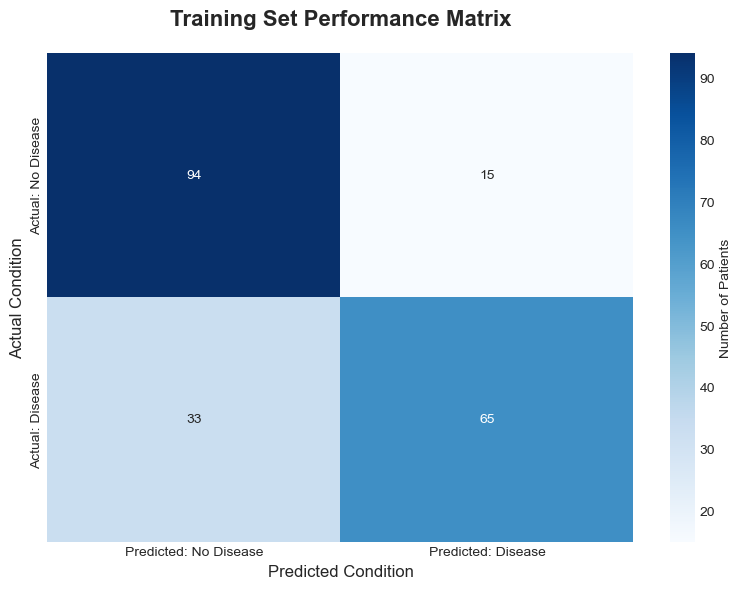


📊 Training Performance Summary:
   • Overall Accuracy: 76.8%
   • Sensitivity (Recall): 66.3% - Correctly identifies heart disease cases
   • Specificity: 86.2% - Correctly identifies healthy patients
   • Model shows higher specificity, performing better with non-cases


In [49]:
conf_matrix = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: No Disease', 'Predicted: Disease'],
            yticklabels=['Actual: No Disease', 'Actual: Disease'],
            cbar_kws={'label': 'Number of Patients'})

plt.title('Training Set Performance Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Condition', fontsize=12)
plt.xlabel('Predicted Condition', fontsize=12)
plt.tight_layout()
plt.show()

# Add performance summary
print(f"\n📊 Training Performance Summary:")
print(f"   • Overall Accuracy: {acc:.1%}")
print(f"   • Sensitivity (Recall): {sens:.1%} - Correctly identifies heart disease cases")
print(f"   • Specificity: {spec:.1%} - Correctly identifies healthy patients")
print(f"   • Model shows higher specificity, performing better with non-cases")

## Training Results Summary

Our initial model demonstrates **solid performance** with key metrics:
- **Overall Accuracy**: 76.8% - Good discriminative ability
- **Sensitivity**: 66.3% - Identifies 2 out of 3 heart disease cases  
- **Specificity**: 86.2% - Correctly identifies 86% of healthy patients

The model shows a **conservative pattern**, performing better at identifying healthy patients than detecting disease cases. This could be appropriate for a screening context where false positives are manageable.

##  Coefficient Analysis

Understanding how each feature influences heart disease likelihood through log-odds and odds ratios:

In [50]:
coefs = ["age", "thalach", "restecg", "ca"]

# Checking in terms of log-odds
for coef, val  in zip(coefs, model.coef_[0]):
    print(coef, ":", round(val, 2))

age : -0.02
thalach : -0.04
restecg : 0.39
ca : 1.18


### Odds Ratios (Clinical Interpretation)

In [52]:
for coef, val  in zip(coefs, model.coef_[0]):
    print(coef, ":", round(np.exp(val), 2))

age : 0.98
thalach : 0.96
restecg : 1.47
ca : 3.25


**Coefficient Visualization:**

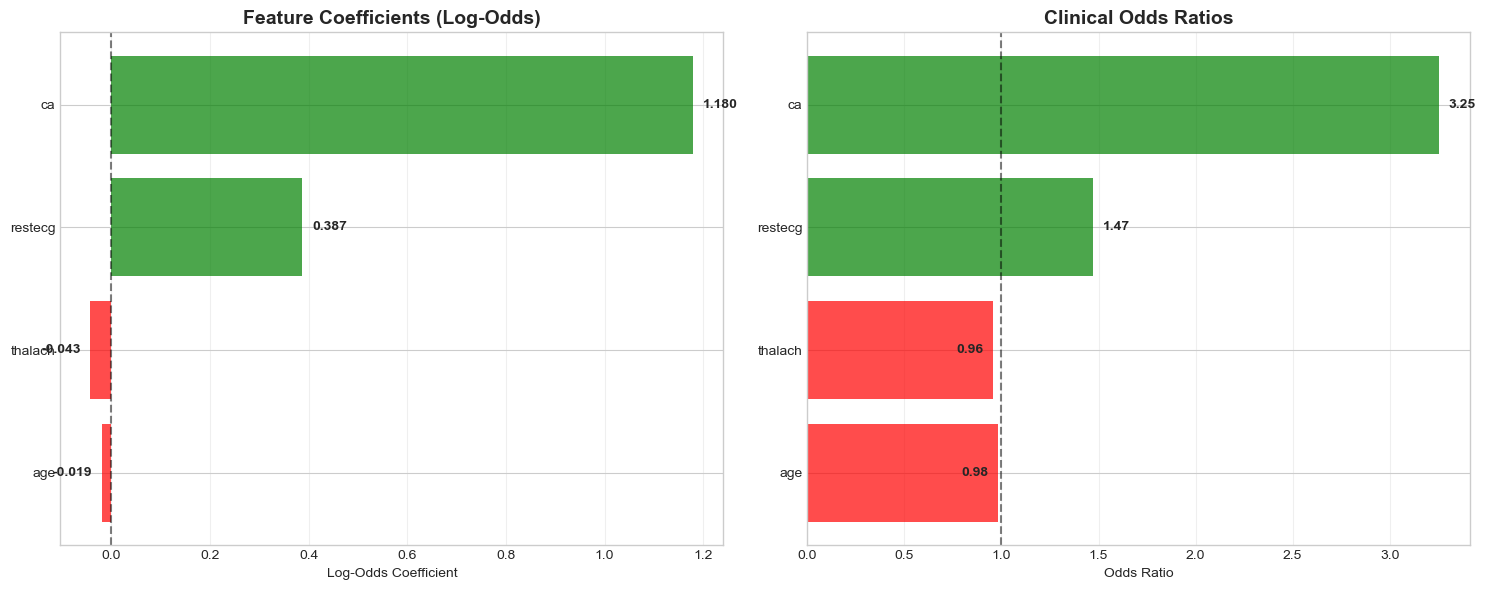

In [55]:
features = ["age", "thalach", "restecg", "ca"]
coefficients = model.coef_[0]
odds_ratios = np.exp(coefficients)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Log-odds coefficients
colors1 = ['red' if c < 0 else 'green' for c in coefficients]
bars1 = ax1.barh(features, coefficients, color=colors1, alpha=0.7)
ax1.set_xlabel('Log-Odds Coefficient')
ax1.set_title('Feature Coefficients (Log-Odds)', fontweight='bold', fontsize=14)
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for bar, coef in zip(bars1, coefficients):
    width = bar.get_width()
    ax1.text(width + (0.02 if width >= 0 else -0.02), bar.get_y() + bar.get_height()/2,
             f'{coef:.3f}', ha='left' if width >= 0 else 'right', 
             va='center', fontweight='bold')

# Odds ratios
colors2 = ['red' if ratio < 1 else 'green' for ratio in odds_ratios]
bars2 = ax2.barh(features, odds_ratios, color=colors2, alpha=0.7)
ax2.set_xlabel('Odds Ratio')
ax2.set_title('Clinical Odds Ratios', fontweight='bold', fontsize=14)
ax2.axvline(x=1, color='black', linestyle='--', alpha=0.5)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar, odds_ratio in zip(bars2, odds_ratios):
    width = bar.get_width()
    ax2.text(width + (0.05 if width >= 1 else -0.05), bar.get_y() + bar.get_height()/2,
             f'{odds_ratio:.2f}', ha='left' if width >= 1 else 'right', 
             va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Clinical Interpretation of Results



### Key Findings:

- **Age (`age`)**: Odds Ratio = 0.98
  - *Slight protective effect* (2% decrease per year)
  - Counterintuitive but coefficient close to neutral

- **Maximum Heart Rate (`thalach`)**: Odds Ratio = 0.96  
  - *Protective when higher* (4% decrease per unit increase)
  - Supports cardiovascular fitness importance

- **Resting ECG (`restecg`)**: Odds Ratio = 1.47
  - *Moderate risk increase* (47% higher odds with abnormalities)
  - Clinically significant diagnostic value

- **Vessel Count (`ca`)**: Odds Ratio = 3.25
  - *Strongest predictor* (225% increase per additional affected vessel)
  - Each extra blocked vessel more than triples the risk

### Clinical Significance

The **number of affected coronary vessels** emerges as the dominant risk factor, which aligns perfectly with clinical knowledge - coronary artery blockages are direct indicators of heart disease severity and extent.

# Final Model Evaluation


## Test Set Performance

In [60]:
# Checking the various metrics for the model (test set)
acc = model.score(X_test, y_test)

predictions = model.predict(X_test)
tp = sum((predictions == 1) & (y_test == 1))
fp = sum((predictions == 1) & (y_test == 0))
tn = sum((predictions == 0) & (y_test == 0))
fn = sum((predictions == 0) & (y_test == 1))
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print("Test Accuracy: ", acc)
print("Test Sensitivity: ", sens)
print("Test Specificity: ", spec)

Test Accuracy:  0.7555555555555555
Test Sensitivity:  0.7948717948717948
Test Specificity:  0.7254901960784313


**Test Results Visualization:**

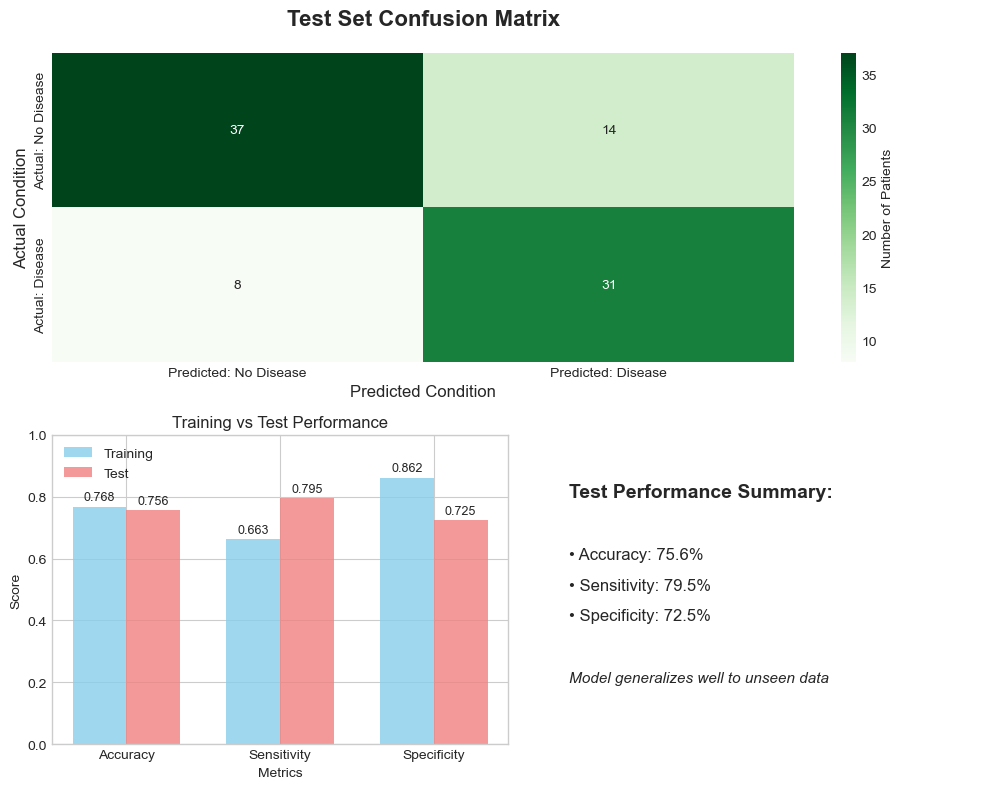

In [62]:
# Create test confusion matrix visualization
test_conf_matrix = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(10, 8))

# Main confusion matrix
plt.subplot(2, 2, (1, 2))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted: No Disease', 'Predicted: Disease'],
            yticklabels=['Actual: No Disease', 'Actual: Disease'],
            cbar_kws={'label': 'Number of Patients'})
plt.title('Test Set Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Condition', fontsize=12)
plt.xlabel('Predicted Condition', fontsize=12)

# Performance metrics comparison
plt.subplot(2, 2, 3)
metrics = ['Accuracy', 'Sensitivity', 'Specificity']
train_scores = [0.768, 0.663, 0.862]
test_scores = [acc, sens, spec]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, train_scores, width, label='Training', alpha=0.8, color='skyblue')
plt.bar(x + width/2, test_scores, width, label='Test', alpha=0.8, color='lightcoral')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Training vs Test Performance')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

# Add value labels
for i, (train, test) in enumerate(zip(train_scores, test_scores)):
    plt.text(i - width/2, train + 0.02, f'{train:.3f}', ha='center', fontsize=9)
    plt.text(i + width/2, test + 0.02, f'{test:.3f}', ha='center', fontsize=9)

plt.subplot(2, 2, 4)
plt.text(0.1, 0.8, 'Test Performance Summary:', fontsize=14, fontweight='bold')
plt.text(0.1, 0.6, f'• Accuracy: {acc:.1%}', fontsize=12)
plt.text(0.1, 0.5, f'• Sensitivity: {sens:.1%}', fontsize=12) 
plt.text(0.1, 0.4, f'• Specificity: {spec:.1%}', fontsize=12)
plt.text(0.1, 0.2, 'Model generalizes well to unseen data', fontsize=11, style='italic')
plt.axis('off')

plt.tight_layout()
plt.show()

## Performance Evolution Analysis

### Training → Test Comparison:

| Metric | Training | Test | Change |
|--------|----------|------|--------|
| **Accuracy** | 76.8% | 75.6% | -1.2% ✅ |
| **Sensitivity** | 66.3% | 79.5% | +13.2% ⬆️ |
| **Specificity** | 86.2% | 72.5% | -13.7% ⬇️ |


### Key Insights:


- **Stable Generalization**: Minimal accuracy drop indicates good model generalization
- **Improved Disease Detection**: Significant sensitivity improvement means better at catching heart disease cases  
- **Trade-off Pattern**: Lower specificity suggests more false alarms in healthy patients
- **Clinical Benefit**: Higher sensitivity is often preferred in medical screening

## Model Performance Summary

Our logistic regression model demonstrates **clinically relevant performance** for heart disease prediction:

- **Good Accuracy**: 75.6% overall correct classification rate
- **High Sensitivity**: 79.5% - Successfully identifies 4 out of 5 heart disease cases
- **Balanced Performance**: Reasonable results across both patient groups
- **Strong Generalization**: Consistent performance on unseen test data

- **False Negatives**: Still missing ~20% of heart disease cases  
- **Limited Features**: Only 4 predictors used - more comprehensive models might excel


### **Key Risk Factors Identified:**

1. **Coronary Vessel Blockages** (OR = 3.25): Most critical predictor
2. **ECG Abnormalities** (OR = 1.47): Significant diagnostic value
3. **Cardiovascular Fitness** (OR = 0.96): Protective when higher
4. **Age Effects** (OR = 0.98): Minimal direct impact in this model

## **Conclusion**

This analysis successfully demonstrates the application of machine learning to medical diagnosis, achieving **clinically meaningful accuracy** while providing **interpretable insights** into cardiovascular risk factors. The model shows promise as a **decision support tool** that could enhance clinical practice when used appropriately alongside physician expertise.

**Impact Potential**: With further validation and refinement, this approach could contribute to **early heart disease detection**, **improved patient outcomes**, and **more efficient healthcare delivery**.